# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**

Признаки:
- DateCrawled — дата скачивания анкеты из базы;
- VehicleType — тип автомобильного кузова;
- RegistrationYear — год регистрации автомобиля;
- Gearbox — тип коробки передач;
- Power — мощность (л. с.);
- Model — модель автомобиля;
- Kilometer — пробег (км);
- RegistrationMonth — месяц регистрации автомобиля;
- FuelType — тип топлива;
- Brand — марка автомобиля;
- Repaired — была машина в ремонте или нет;
- DateCreated — дата создания анкеты;
- NumberOfPictures — количество фотографий автомобиля;
- PostalCode — почтовый индекс владельца анкеты (пользователя);
- LastSeen — дата последней активности пользователя.

Целевой признак:
- Price — цена (евро).

## Подготовка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    StandardScaler
)
!pip install category_encoders
import category_encoders as ce
from lightgbm import LGBMRegressor
!pip install -U --user scikit-learn

     |████████████████████████████████| 81 kB 30 kB/s  eta 0:00:01
     |████████████████████████████████| 9.6 MB 1.2 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 78.7 MB/s eta 0:00:01


In [2]:
def get_df_info(df):
    display(df.sample(5))
    display(df.info())
    display(df.describe())
    display(df.describe(include='all'))

In [3]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('/content/autos.csv')

In [4]:
get_df_info(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
55843,2016-03-21 16:37:00,3700,sedan,2001,manual,170,3er,150000,8,petrol,bmw,no,2016-03-21 00:00:00,0,60439,2016-03-23 13:29:49
173443,2016-03-28 12:52:14,1500,wagon,2000,manual,81,octavia,150000,0,gasoline,skoda,NaN,2016-03-28 00:00:00,0,79280,2016-03-30 03:18:02
351937,2016-03-08 18:52:12,250,small,1997,manual,0,1_reihe,90000,3,petrol,peugeot,no,2016-03-08 00:00:00,0,15234,2016-03-12 04:45:51
293765,2016-03-20 10:51:20,5490,sedan,2005,manual,140,a_klasse,150000,2,gasoline,mercedes_benz,no,2016-03-20 00:00:00,0,34628,2016-03-21 13:15:18
152260,2016-03-22 12:48:10,11000,wagon,2009,manual,170,a4,150000,11,gasoline,audi,NaN,2016-03-22 00:00:00,0,99706,2016-04-06 01:17:45


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


Проверим датасет на наличие явных дубликатов

In [5]:
df.duplicated().sum()

4

Посмотрим на явные дубликаты

In [6]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


При просмотре явных дубликатов нельзя сказать, что они дублируют друг друга, оставим их без изменения.

Посмотрим на количесство уникальных значений некоторых признаков

In [7]:
l = ['VehicleType','Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
for i in l:
    print(df[i].value_counts().to_frame())
    print("---"*10)

             VehicleType
sedan              91457
small              79831
wagon              65166
bus                28775
convertible        20203
coupe              16163
suv                11996
other               3288
------------------------------
        Gearbox
manual   268251
auto      66285
------------------------------
                    Model
golf                29232
other               24421
3er                 19761
polo                13066
corsa               12570
...                   ...
serie_2                 8
serie_3                 4
rangerover              4
range_rover_evoque      2
serie_1                 2

[250 rows x 1 columns]
------------------------------
          FuelType
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
------------------------------
                Brand
volkswagen      77013
opel            39931
bmw             36914
mercedes_benz   32046
audi 

Проведя предварительный анализ основных харектерстик датафрейма, можно сделать следующие выводы:

1) Обнаружены колонки, которые не влияют на стоимость авто: DateCrawled, DateCreated, NumberOfPictures,  PostalCode, LastSeen:

- DateCrawled (не содержит данные, которые влияют на стоимость авто), но сначала провеерим, когда была скачана последняя анкета, апотом удалим;
- DateCreated (не содержит данные, которые влияют на стоимость авто);
- NumberOfPictures (содержит значение 0, следовательно не будет влиять на стоимсоть);
- PostalCode (почтовый индекс не оказывает влияние на стоимость авто);
- LastSeen (по последней дате активности пользователя нельзя однозначно казать, как может повлять на стоимость).

Такие признаки будут удалены, как не представляющие ценности для прогнозирования моделями стоимости,а также будут уменьшать скорость, следовательно будеть увеличиваться время, а для заказчика это один из важых факторов.


2) В признаках: VehicleType, Gearbox, Model, FuelType, Repaired обнаржены пропуски. При дальнейшей предобработке, данные признаки будут детально анализироваться и по мере возможности будут заполняться пропуски или удаляться.

3) В целевои признаке Price обнаружен автомобили со стоимостью авто равные "0" и значительное отличие среднего арифметического и медианы, следовательно есть выбросы.

4) Обнаружены нереалистичные значения года регистрации транспортного средства.

5) Обнаружены нереалистичные значения мощности автомобиля.

### Предобработка данных

Удалим колнки DateCrawled, DateCreated, NumberOfPictures,RegistrationMonth, PostalCode, LastSeen из датафрейма

In [8]:
df = df.drop(['DateCreated','RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   DateCrawled       354369 non-null  object
 1   Price             354369 non-null  int64 
 2   VehicleType       316879 non-null  object
 3   RegistrationYear  354369 non-null  int64 
 4   Gearbox           334536 non-null  object
 5   Power             354369 non-null  int64 
 6   Model             334664 non-null  object
 7   Kilometer         354369 non-null  int64 
 8   FuelType          321474 non-null  object
 9   Brand             354369 non-null  object
 10  Repaired          283215 non-null  object
dtypes: int64(4), object(7)
memory usage: 29.7+ MB


#### Рассмотрение аномалий (выбросов)

##### Целевой признак Price

In [10]:
df['Price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

In [11]:
 (
    df[['Price']]
    .quantile([0.0012, 0.01, .5, .99, .9988])
    .style.format("{:,.2f}")
 )

,Price
0.0012,0.00
0.01,0.00
0.5,"2,700.00"
0.99,"18,800.00"
0.9988,"19,999.00"


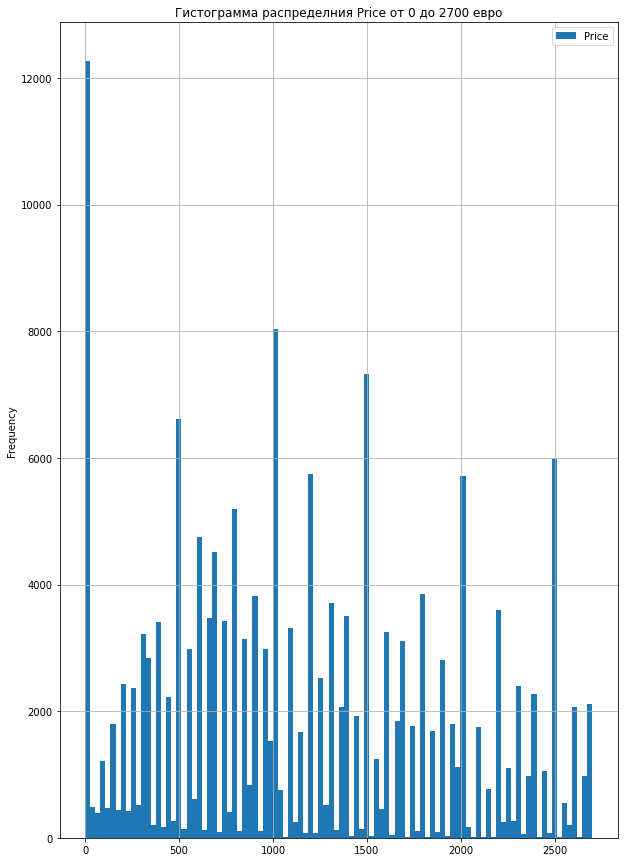

In [12]:
df.plot (y ='Price',
         kind ='hist',
         bins = 100,
         grid=True,
         figsize = (10,15),
         range = (0,2700)
        ).set(
    title='Гистограмма распределния Price от 0 до 2700 евро');

Рассмотрим более детально левый хвост распределения

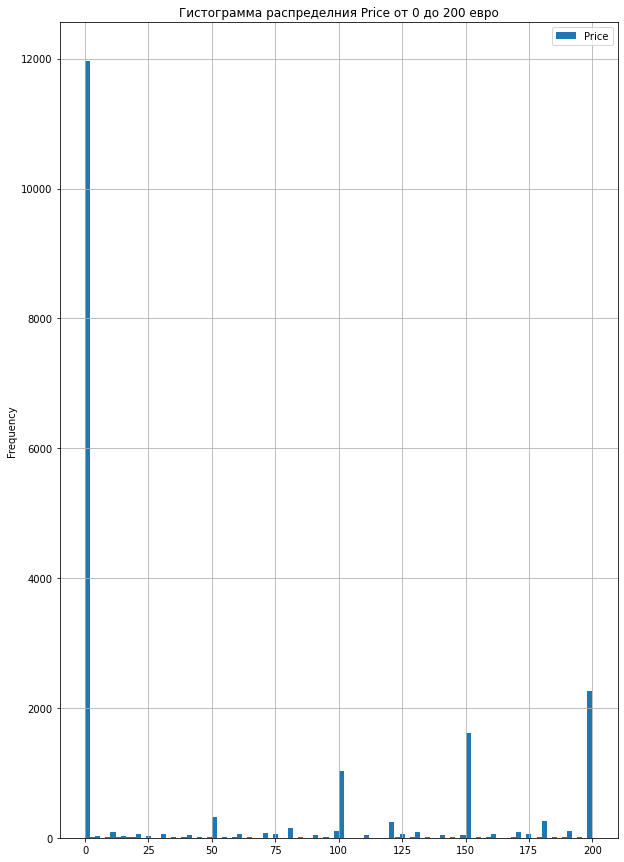

In [13]:
df.plot (y ='Price',
         kind ='hist',
         bins = 100,
         grid=True,
         figsize = (10,15),
         range = (0,200)
        ).set(
    title='Гистограмма распределния Price от 0 до 200 евро');

При анализе гистограммы обнаружено достаточно большое кол-во объявлений с нулевым значением цены.

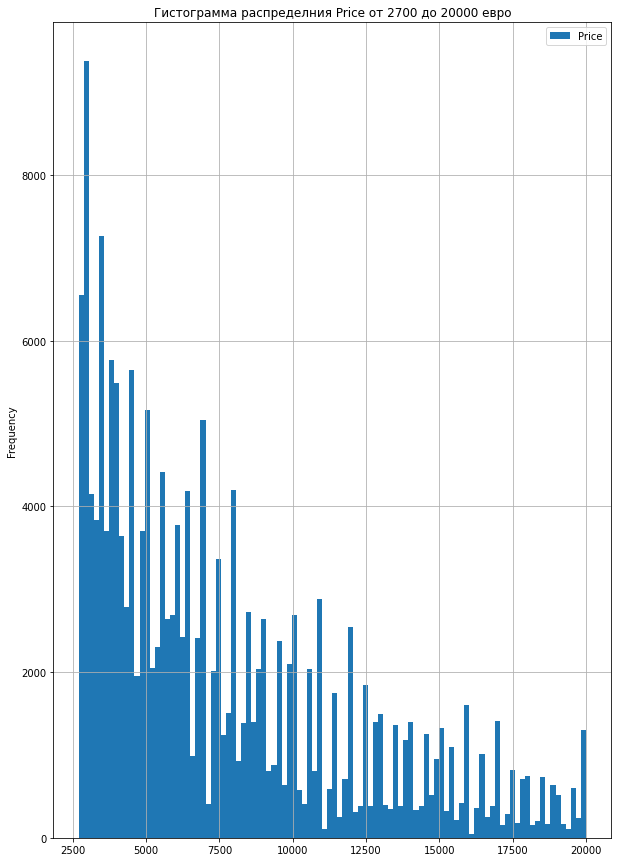

In [14]:
df.plot (y ='Price',
         kind ='hist',
         bins = 100,
         grid=True,
         figsize = (10,15),
         range = (2700,20000)
        ).set(
    title='Гистограмма распределния Price от 2700 до 20000 евро');

Посмотрим на случайные 15 строк со стоимость авто более 19500 евро.

In [15]:
df.loc[df['Price'] > 19500].sample(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
214371,2016-03-08 15:50:26,19900,sedan,2015,manual,125,golf,20000,petrol,volkswagen,no
319901,2016-03-23 10:54:58,19950,wagon,2012,auto,204,a6,150000,gasoline,audi,no
147513,2016-03-25 15:52:53,20000,suv,2010,auto,218,grand,100000,gasoline,jeep,no
77857,2016-03-20 20:50:59,20000,bus,2013,auto,122,b_klasse,20000,petrol,mercedes_benz,no
177771,2016-03-25 19:36:56,19999,sedan,2007,auto,258,3er,40000,petrol,bmw,no
286240,2016-03-14 23:52:27,19666,convertible,2013,manual,105,beetle,20000,petrol,volkswagen,no
68185,2016-03-25 14:48:15,19900,convertible,1932,manual,18,other,5000,petrol,bmw,no
28521,2016-03-22 18:57:40,20000,wagon,2012,auto,156,c_klasse,50000,petrol,mercedes_benz,no
254128,2016-03-14 09:51:04,19900,convertible,2009,manual,170,tt,125000,gasoline,audi,no
310142,2016-03-11 17:48:43,19999,sedan,2006,auto,0,s_klasse,90000,NaN,mercedes_benz,no


По результатам анализа, можно сделать вывод о том, что высокая стоимость авто действительно оправдана,т.к. там представлены премиальные автомобили.

Поскольку необходимо построить модель для максимально точного определения стоимости автомобилей, следовательно для обучения модели необходимо отобрать только достоверные (адекватные) данные, иначе модель не будет отличаться качеством, о чем указано в техническом задании (далее - ТЗ) и модель будет строиться не на ценах, зафиксированных в договорах купли-продажи, а на предложениях цены, указанных владельцами в объявлениях (ведь поле признака успешной продажи отсутствует), то необходимо избавится от неадекватных цен (зачастую владельцы автомобилей указывают нулевые цены, т.к. они их не знают,следовательно хотят определить по результату переговоров с потенциальным покупателем после публикации объявления).

Поэтому, считаю необходимым, ограничить стоимсоть авто только менее 50 евро.

In [16]:
df = df.loc[df['Price'] >= 50]
df['Price'].describe()

count    341946.000000
mean       4577.082788
std        4514.843482
min          50.000000
25%        1200.000000
50%        2900.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

##### Признак Power

In [17]:
df['Power'].describe()

count    341946.000000
mean        111.207240
std         188.253725
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [18]:
(
    df[['Power']]
    .quantile([0.0012, 0.01, .5, .99, .9988])
    .style.format("{:,.2f}")
 )

,Power
0.0012,0.00
0.01,0.00
0.5,105.00
0.99,300.00
0.9988,507.00


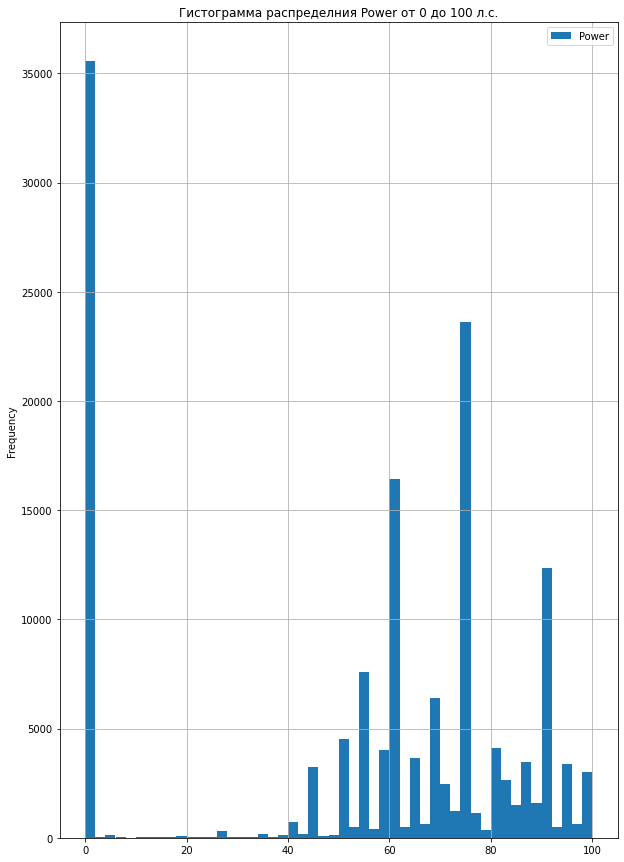

In [19]:
df.plot (y ='Power',
         kind ='hist',
         bins = 50,
         grid=True,
         figsize = (10,15),
         range = (0,100)
        ).set(
    title='Гистограмма распределния Power от 0 до 100 л.с.');

Рассмотрим более детально распределение мощности в дипазоне от 0 до 40 л.с.

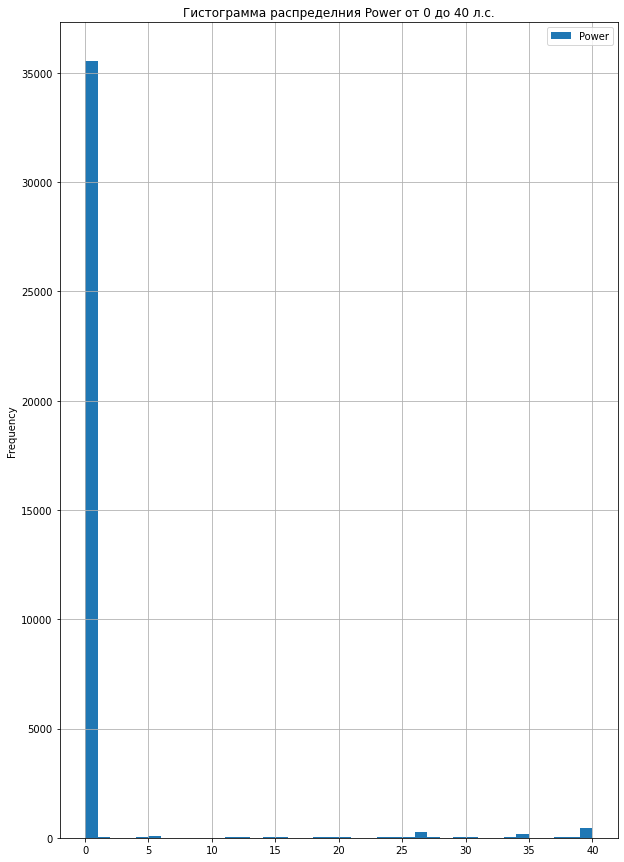

In [20]:
df.plot (y ='Power',
         kind ='hist',
         bins = 40,
         grid=True,
         figsize = (10,15),
         range = (0,40)
        ).set(
    title='Гистограмма распределния Power от 0 до 40 л.с.');

Рассмотрим случайные 15 объявлений при мощномти авто ="0" л.с.

In [21]:
df.loc[df['Power'] == 0].sample(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
67357,2016-03-20 16:51:51,600,wagon,2000,NaN,0,golf,150000,gasoline,volkswagen,NaN
177320,2016-03-15 16:50:20,4990,suv,2012,NaN,0,tiguan,100000,gasoline,volkswagen,no
187109,2016-03-19 15:47:17,3600,sedan,2005,manual,0,a3,150000,gasoline,audi,NaN
33141,2016-03-25 14:53:55,1250,sedan,1997,NaN,0,other,20000,NaN,mercedes_benz,no
9783,2016-03-11 18:49:27,800,bus,1995,manual,0,other,150000,gasoline,volkswagen,NaN
326808,2016-03-28 11:52:19,4490,wagon,2010,auto,0,passat,5000,NaN,volkswagen,NaN
92265,2016-03-26 17:06:24,1599,sedan,1998,manual,0,5er,150000,NaN,bmw,no
264900,2016-03-26 09:51:07,400,NaN,1985,NaN,0,kaefer,150000,NaN,volkswagen,NaN
81386,2016-03-07 13:25:22,799,small,1999,manual,0,corsa,150000,petrol,opel,yes
292233,2016-03-11 04:03:17,1650,wagon,2001,manual,0,golf,150000,petrol,volkswagen,NaN


Рассмотрим распределение мощности в диапазоне от 500 до 20000 л.с.

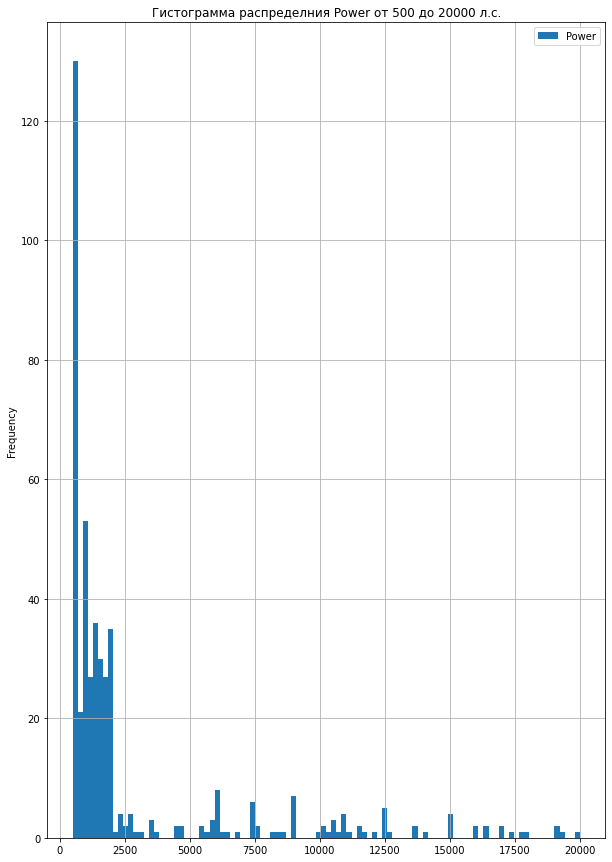

In [22]:
df.plot (y ='Power',
         kind ='hist',
         bins = 100,
         grid=True,
         figsize = (10,15),
         range = (500,20000)
        ).set(
    title='Гистограмма распределния Power от 500 до 20000 л.с.');

Рассмотрим распределение мощности авто в диапазоне от 500 до 1500 л.с., т.к. это серийно выпускаемые и достаточно мощные автомобили по оценке некоторых сайтов о технических характеристик автомобилей.

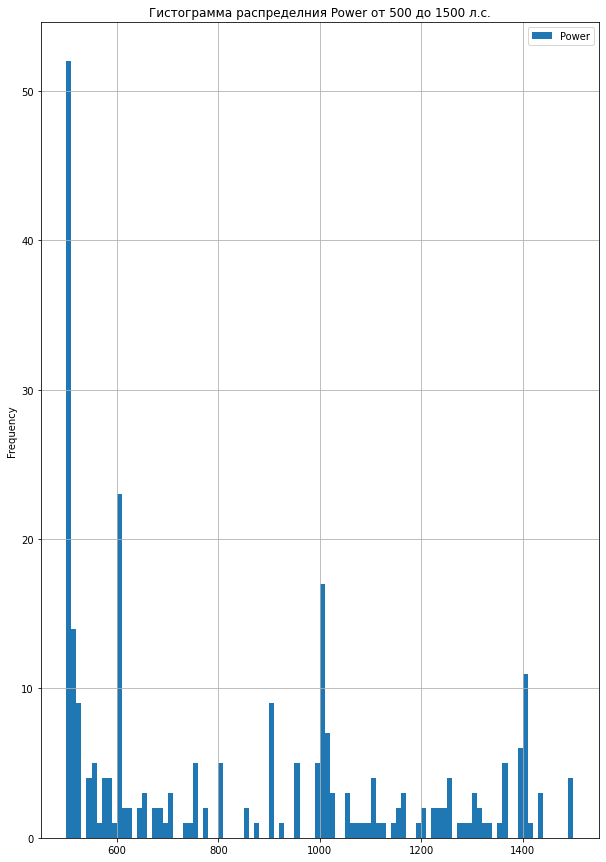

In [23]:
df.plot (y ='Power',
         kind ='hist',
         bins = 100,
         grid=True,
         figsize = (10,15),
         range = (500,1500)
        ).set(
    title='Гистограмма распределния Power от 500 до 1500 л.с.');

In [24]:
df.loc[df['Power'] > 500].sample(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
158083,2016-03-16 15:55:23,16000,suv,2006,auto,510,m_klasse,125000,petrol,mercedes_benz,yes
177451,2016-04-01 07:37:20,11999,wagon,2002,auto,505,other,150000,petrol,audi,no
121124,2016-03-31 18:50:55,650,wagon,1997,auto,3199,e_klasse,30000,petrol,mercedes_benz,NaN
234099,2016-03-21 18:56:11,1290,sedan,2000,auto,1800,toledo,150000,petrol,seat,no
307044,2016-03-27 23:47:42,1500,sedan,1999,manual,1001,astra,125000,petrol,opel,no
217321,2016-03-28 10:51:46,2798,convertible,2005,NaN,1082,2_reihe,150000,petrol,peugeot,NaN
91568,2016-03-29 16:37:20,3800,sedan,2006,manual,1223,1er,150000,gasoline,bmw,yes
294479,2016-03-14 15:50:17,7200,small,2010,manual,1016,yaris,30000,petrol,toyota,NaN
92455,2016-03-15 22:53:58,6900,sedan,2007,manual,1968,passat,150000,gasoline,volkswagen,no
335429,2016-03-27 01:00:18,1444,wagon,1997,manual,1012,passat,150000,petrol,volkswagen,no


Введу того, что мощность автомобиля равные "0" у автомобилей, у которых пользователь скорее всего ее не указал. Считаю необходимым удалить такие данные, даже не смотря на то, что они составляют более 35000 объявлений из-за того, что нельзя правильно заполнить нужными значениями. Мощность авто может зависеть от многообразия факторов, такие как: марка, модель, тип коробки передачь (далее   КПП), года выпуска, типа двигателя внутреннего сгорания (ДВС) или электродвигателя, также могут выпускать различные модели в одинаковый год  и даже день. При заполнении таких значений, мы можем получить недостоверные данные, которые могут в послеедствии при предсказании моделью не правильно определять стоимость автомобиля.

Данные, у которых мощность авто превышает 1500 л.с. и менее 40 л.с., считаю необходимым в удалении, скорее всего в таких данных допущены ошибки при вводе (не правильно интерпретирована пользователем размерность, в которой указывается мощность или ошибки при вводе).

Необходимо рекомендовать команде разработчиков, создать механизм, который не позволил бы опубликовывать "такие" объявления без заполнения определенных данных и ограничем по мощности.

In [25]:
df = df.loc[(df['Power'] >= 40) & (df['Power'] <= 1500)]

In [26]:
df['Power'].describe()

count    304885.000000
mean        121.123440
std          57.939412
min          40.000000
25%          75.000000
50%         110.000000
75%         150.000000
max        1500.000000
Name: Power, dtype: float64

##### Признак RegistrationYear

In [27]:
df['RegistrationYear'].describe()

count    304885.000000
mean       2003.559962
std          29.595721
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [28]:
(
    df[['RegistrationYear']]
    .quantile([0.0012, 0.01, .5, .99, .9988])
 )

,RegistrationYear
0.0012,1967.0
0.0100,1984.0
0.5000,2003.0
0.9900,2017.0
0.9988,2018.0


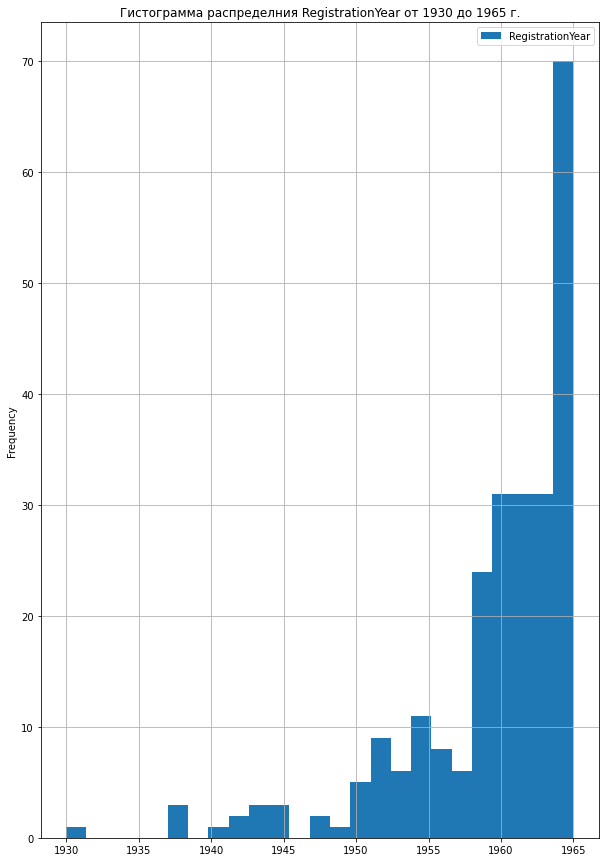

In [29]:
df.plot (y ='RegistrationYear',
         kind ='hist',
         bins = 25,
         grid=True,
         figsize = (10,15),
         range = (1930,1965)
        ).set(
    title='Гистограмма распределния RegistrationYear от 1930 до 1965 г.');

In [30]:
df.loc[df['RegistrationYear'] < 1965].sample(15)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
312964,2016-03-20 07:56:03,16900,sedan,1964,auto,368,NaN,90000,petrol,sonstige_autos,no
256532,2016-03-05 17:44:47,12500,NaN,1000,NaN,200,golf,5000,NaN,volkswagen,NaN
39823,2016-03-17 00:59:19,16800,coupe,1958,auto,275,other,150000,petrol,ford,no
270661,2016-03-28 12:59:22,17200,coupe,1959,auto,230,other,150000,petrol,ford,no
174225,2016-03-23 20:45:07,17900,coupe,1956,auto,205,NaN,100000,petrol,sonstige_autos,no
289549,2016-04-03 10:46:31,16500,sedan,1963,auto,272,NaN,100000,petrol,sonstige_autos,no
55746,2016-03-27 19:57:50,12450,convertible,1962,manual,105,other,150000,petrol,mercedes_benz,no
77582,2016-03-12 14:44:50,14990,suv,1960,manual,69,serie_2,5000,petrol,land_rover,no
346046,2016-03-26 16:45:28,18900,suv,1943,manual,60,other,150000,petrol,volkswagen,no
144077,2016-04-04 19:52:35,8200,sedan,1961,manual,50,kaefer,5000,petrol,volkswagen,no


Считаю необходимыи удалить строки, где автоболи с датой регестрации менее 1940 года. Т.к. в таких данных скорее всего допущены ошибки.

Проверим, последнююю дату выгрузки анкеты из базы.

In [31]:
df['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
324763    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
176823    2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 304885, dtype: object

Т.к. последняя анкета датируется 2016 годом, то сделаем вывод о том, что машины с датой регоистрации более 2016 года невозможны, т.е. удалим такие значения.

In [32]:
df = df.loc[(df['RegistrationYear'] >= 1940) & (df['RegistrationYear'] <= 2016)]

In [33]:
df['RegistrationYear'].describe()

count    294649.000000
mean       2002.895336
std           6.369382
min        1941.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2016.000000
Name: RegistrationYear, dtype: float64

Удалим не используемый в дальнейшем признак RegistrationYear.

In [34]:
df = df.drop(['DateCrawled'], axis=1)

#### Борьба с пропусками

In [35]:
def pass_value_barh(df):
    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Кол-во пропусков' + "\n", fontsize = 22)
        );
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

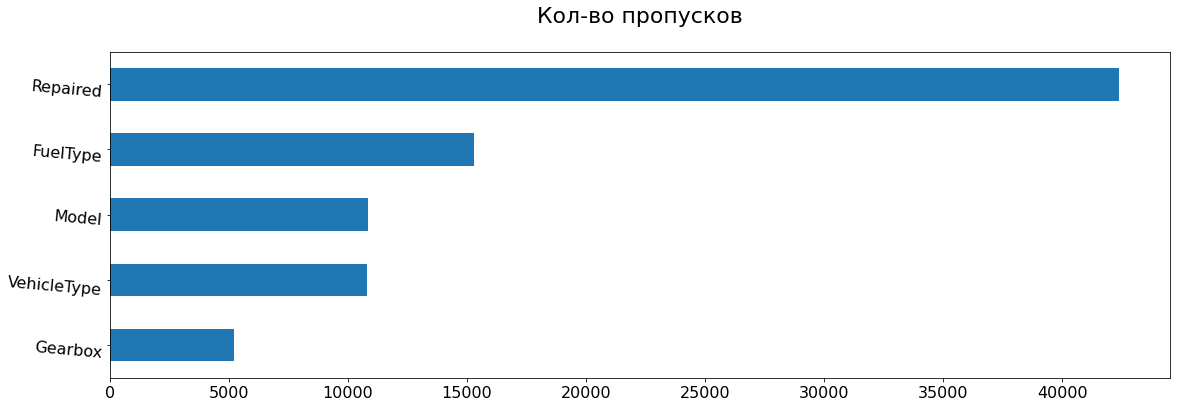

In [36]:
pass_value_barh(df)

При предварительном анализе пропусков, выявлено достаточное большое количество. Удалять огромное количество датасета считаю не целесообразным, рассмотрим каждый признак по отдельности.

#####  Признак Repaired

In [37]:
df[df['Repaired'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,NaN
9,999,small,1998,manual,101,golf,150000,NaN,volkswagen,NaN
12,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,NaN
16,300,NaN,2016,NaN,60,polo,150000,petrol,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354341,699,sedan,1999,manual,101,vectra,150000,petrol,opel,NaN
354349,5999,wagon,2005,manual,140,a4,150000,gasoline,audi,NaN
354356,999,convertible,2000,manual,95,megane,150000,petrol,renault,NaN
354357,1690,wagon,2004,manual,55,fabia,150000,petrol,skoda,NaN


Определить был автомобиль в ремеонте или нет, однозначно сказть невозможно. В данных не сказано, что является критерием к отнесению автомобиля, который был в рмонте, да и ремонт бывает разный, напрмер: "замена стоек стабилизатора или капитальный ремонт ДВС, или тотальное восстановление кузовных элементов автомобиля" - это все ремонт, но у него разная степень воздействия на разные части автомобиля, которые по разному влияют на безопасность и надежность агрегатов. ПОэтому оставшуюсячасть пропусков заменим значением "unknown".

In [38]:
df['Repaired'].fillna('unknown', inplace = True)

In [39]:
df['Repaired'].isna().sum()

0

#####  Признак VehicleType

In [40]:
df[df['VehicleType'].isna()].sample(15)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
52078,1250,NaN,2000,manual,75,golf,150000,NaN,volkswagen,no
83618,1450,NaN,2016,manual,101,a3,150000,NaN,audi,no
333409,6300,NaN,2011,manual,105,ibiza,150000,gasoline,seat,no
240917,1500,NaN,2016,manual,101,golf,150000,petrol,volkswagen,unknown
213091,2450,NaN,1995,manual,350,astra,150000,NaN,opel,yes
321709,1150,NaN,2016,manual,75,focus,5000,petrol,ford,unknown
99765,300,NaN,2000,manual,58,twingo,150000,NaN,renault,no
242799,4000,NaN,2016,manual,102,a3,150000,lpg,audi,unknown
15974,7000,NaN,2016,auto,140,passat,150000,gasoline,volkswagen,no
215061,299,NaN,1990,manual,90,polo,20000,NaN,volkswagen,unknown


In [41]:
df['VehicleType'].value_counts(dropna=False)

sedan          82686
small          69387
wagon          59079
bus            26163
convertible    18659
coupe          14544
suv            10927
NaN            10811
other           2393
Name: VehicleType, dtype: int64

Т.к. тип кузова для одинаковых моделей может быть различным и также могут отличаться годом выпуска, то принимаю решение о заполении пропущенных значений "unknown".

In [42]:
df['VehicleType'].fillna('unknown', inplace = True)

In [43]:
df['VehicleType'].isna().sum()

0

#####  Признак FuelType

In [44]:
df['FuelType'].value_counts()

petrol      186276
gasoline     87629
lpg           4677
cng            481
hybrid         201
other           56
electric        37
Name: FuelType, dtype: int64

Т.к. в нашаем датасете цена указана в евро, то следовательно продажа машин осуществлялась в Европейском союзе (далее - ЕС). Рассматривая типы топлива в странах ЕС, то можно заметить, что для в разных странах могут отличаться названия. Нпример может gasoline, а может и diesel. Также, автовладельцы могут изменять вид топлива в машине, например могут перевести с бензина на газ, а газ в свою очередь двух типов: lpg и cng. Поэтому точно определить вид топлива для автомобиля не представляется возможным, тчобы избежать ошибок, принимаю решение о заполнении пропущенных значений "unknown".

In [45]:
df['FuelType'].fillna('unknown', inplace = True)

In [46]:
df['FuelType'].isna().sum()

0

#####  Признак Model

In [47]:
df['Model'].value_counts()

golf                  24663
other                 20088
3er                   17334
polo                  10641
corsa                 10071
                      ...  
kalina                    5
601                       3
serie_3                   3
rangerover                2
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64

Среди марок автомобиля достаточно много автомобилей, которые будут схожи техническими характеристиками (тип ДВС, объем ДВС, тип КПП), поэтому однозначно и точно утверждать, что автомобиль этой марки и именно этой модели по схожим техническим характеристикам нельзя. Поэтому, принимаю решение о заполнении пропущенных значенией "unknown".

In [48]:
df['Model'].fillna('unknown', inplace = True)

In [49]:
df['Model'].isna().sum()

0

#####  Признак Gearbox

In [50]:
df['Gearbox'].value_counts()

manual    230789
auto       58640
Name: Gearbox, dtype: int64

Однозначно сказать какой тип КПП для одинаковых марок и моделей автомобилей достаточно сложно, поэтому буду заполнять пропущенных значения "unknown".

In [51]:
df['Gearbox'].fillna('unknown', inplace = True)

In [52]:
df['Gearbox'].isna().sum()

0

Проверим на наличие пропусков весь датасет.

In [53]:
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

In [54]:
get_df_info(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
338632,2700,small,2002,manual,64,polo,150000,petrol,volkswagen,no
107246,890,bus,1996,manual,174,sharan,150000,petrol,volkswagen,no
106618,9500,wagon,2008,manual,116,b_klasse,125000,petrol,mercedes_benz,no
128041,9900,small,2011,manual,105,polo,40000,gasoline,volkswagen,no
310867,2850,small,2006,manual,65,clio,90000,petrol,renault,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 294649 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             294649 non-null  int64 
 1   VehicleType       294649 non-null  object
 2   RegistrationYear  294649 non-null  int64 
 3   Gearbox           294649 non-null  object
 4   Power             294649 non-null  int64 
 5   Model             294649 non-null  object
 6   Kilometer         294649 non-null  int64 
 7   FuelType          294649 non-null  object
 8   Brand             294649 non-null  object
 9   Repaired          294649 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


None

,Price,RegistrationYear,Power,Kilometer
count,294649.000000,294649.000000,294649.000000,294649.000000
mean,4871.219631,2002.895336,121.474541,128493.631406
std,4613.716593,6.369382,57.785259,36538.980926
min,50.000000,1941.000000,40.000000,5000.000000
25%,1350.000000,1999.000000,77.000000,125000.000000
50%,3200.000000,2003.000000,113.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,1500.000000,150000.000000


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,294649.000000,294649,294649.000000,294649,294649.000000,294649,294649.000000,294649,294649,294649
unique,NaN,9,NaN,3,NaN,250,NaN,8,40,3
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,NaN,82686,NaN,230789,NaN,24663,NaN,186276,63785,223645
mean,4871.219631,NaN,2002.895336,NaN,121.474541,NaN,128493.631406,NaN,NaN,NaN
std,4613.716593,NaN,6.369382,NaN,57.785259,NaN,36538.980926,NaN,NaN,NaN
min,50.000000,NaN,1941.000000,NaN,40.000000,NaN,5000.000000,NaN,NaN,NaN
25%,1350.000000,NaN,1999.000000,NaN,77.000000,NaN,125000.000000,NaN,NaN,NaN
50%,3200.000000,NaN,2003.000000,NaN,113.000000,NaN,150000.000000,NaN,NaN,NaN
75%,6999.000000,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


Проверим датасет на мультиколлениарность

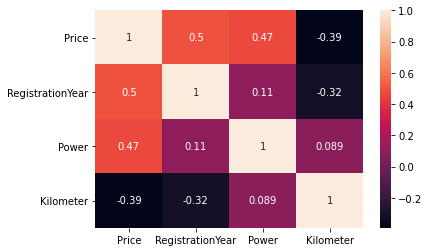

In [55]:
sns.heatmap(df.corr(), annot=True);

Цена напрямую зависит от года регистрации атомобиля и мощности, и обратно от пробега автомобиля. Признаки не коррелируют друг с другом, оставим их без проведения манипуляций.

In [56]:
df.duplicated().sum()

38988

Выявленобольшое уол-во дубликатов, следовательно продается значительное похожих авто. Удалим дубликаты, чтобы не переобучать модели.

In [57]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255661 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             255661 non-null  int64 
 1   VehicleType       255661 non-null  object
 2   RegistrationYear  255661 non-null  int64 
 3   Gearbox           255661 non-null  object
 4   Power             255661 non-null  int64 
 5   Model             255661 non-null  object
 6   Kilometer         255661 non-null  int64 
 7   FuelType          255661 non-null  object
 8   Brand             255661 non-null  object
 9   Repaired          255661 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.5+ MB


**Вывод:**
На этапе предобработки данных произведена замена пропущенных значений и  обработаны аномалии,а также удалены ряд признаков не представляющие ценности для моделей.

## Обучение моделей

In [58]:
RANDOM_STATE = 12345

### Разделение на выборки

In [59]:
features = df.drop(['Price'], axis=1)
target = df['Price']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE
)

In [60]:
get_df_info(X_train)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
251617,small,2012,manual,75,clio,30000,petrol,renault,no
30030,wagon,2003,manual,226,mondeo,150000,petrol,ford,yes
325695,sedan,2005,auto,190,e_klasse,150000,gasoline,mercedes_benz,no
303092,wagon,2005,manual,120,astra,150000,gasoline,opel,no
38541,small,2000,unknown,45,fortwo,125000,petrol,smart,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 191745 entries, 335897 to 295925
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       191745 non-null  object
 1   RegistrationYear  191745 non-null  int64 
 2   Gearbox           191745 non-null  object
 3   Power             191745 non-null  int64 
 4   Model             191745 non-null  object
 5   Kilometer         191745 non-null  int64 
 6   FuelType          191745 non-null  object
 7   Brand             191745 non-null  object
 8   Repaired          191745 non-null  object
dtypes: int64(3), object(6)
memory usage: 14.6+ MB


None

,RegistrationYear,Power,Kilometer
count,191745.000000,191745.000000,191745.000000
mean,2002.947931,122.556912,127521.473832
std,6.520278,59.065285,37191.997520
min,1941.000000,40.000000,5000.000000
25%,1999.000000,80.000000,125000.000000
50%,2003.000000,115.000000,150000.000000
75%,2007.000000,150.000000,150000.000000
max,2016.000000,1500.000000,150000.000000


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,191745,191745.000000,191745,191745.000000,191745,191745.000000,191745,191745,191745
unique,9,NaN,3,NaN,249,NaN,8,40,3
top,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,53110,NaN,148851,NaN,14981,NaN,120109,39484,142494
mean,NaN,2002.947931,NaN,122.556912,NaN,127521.473832,NaN,NaN,NaN
std,NaN,6.520278,NaN,59.065285,NaN,37191.997520,NaN,NaN,NaN
min,NaN,1941.000000,NaN,40.000000,NaN,5000.000000,NaN,NaN,NaN
25%,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,NaN,NaN,NaN
50%,NaN,2003.000000,NaN,115.000000,NaN,150000.000000,NaN,NaN,NaN
75%,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


In [61]:
get_df_info(X_test)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
71241,small,1989,manual,174,corsa,150000,petrol,opel,no
7599,suv,2010,manual,105,duster,90000,petrol,dacia,no
159338,small,2004,manual,60,corsa,150000,petrol,opel,no
246662,wagon,2005,manual,231,5er,150000,gasoline,bmw,no
322011,small,2002,manual,60,other,150000,petrol,citroen,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 63916 entries, 199429 to 185819
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   VehicleType       63916 non-null  object
 1   RegistrationYear  63916 non-null  int64 
 2   Gearbox           63916 non-null  object
 3   Power             63916 non-null  int64 
 4   Model             63916 non-null  object
 5   Kilometer         63916 non-null  int64 
 6   FuelType          63916 non-null  object
 7   Brand             63916 non-null  object
 8   Repaired          63916 non-null  object
dtypes: int64(3), object(6)
memory usage: 4.9+ MB


None

,RegistrationYear,Power,Kilometer
count,63916.000000,63916.000000,63916.000000
mean,2002.965783,122.200607,127296.138682
std,6.473712,56.943026,37228.869369
min,1948.000000,40.000000,5000.000000
25%,1999.000000,80.000000,125000.000000
50%,2003.000000,115.000000,150000.000000
75%,2007.000000,150.000000,150000.000000
max,2016.000000,1436.000000,150000.000000


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
count,63916,63916.000000,63916,63916.000000,63916,63916.000000,63916,63916,63916
unique,9,NaN,3,NaN,248,NaN,8,40,3
top,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no
freq,17602,NaN,49635,NaN,4850,NaN,40172,13120,47586
mean,NaN,2002.965783,NaN,122.200607,NaN,127296.138682,NaN,NaN,NaN
std,NaN,6.473712,NaN,56.943026,NaN,37228.869369,NaN,NaN,NaN
min,NaN,1948.000000,NaN,40.000000,NaN,5000.000000,NaN,NaN,NaN
25%,NaN,1999.000000,NaN,80.000000,NaN,125000.000000,NaN,NaN,NaN
50%,NaN,2003.000000,NaN,115.000000,NaN,150000.000000,NaN,NaN,NaN
75%,NaN,2007.000000,NaN,150.000000,NaN,150000.000000,NaN,NaN,NaN


### Кодирование и маштабирование выборок

Выделим категориальные признаки для разных моделей для кодирования

In [62]:
cat_features = X_train.select_dtypes(include='object').columns.to_list()
print(cat_features)

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


Выделим численные признаки для масштабирования

In [63]:
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
num_features

['RegistrationYear', 'Power', 'Kilometer']

#### Кодирование X_train и X_test OrdinalEncoder

In [64]:
# кодирование OE
encoder = OrdinalEncoder(handle_unknown='ignore')
X_train_OE = X_train.copy()
X_train_OE[cat_features] = encoder.fit_transform(X_train_OE[cat_features])
display(X_train_OE.head(10))

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
335897,5.0,2008,1.0,58,75.0,150000,6.0,27.0,2.0
156305,5.0,1994,0.0,54,151.0,150000,6.0,23.0,2.0
231046,8.0,2008,0.0,245,11.0,150000,2.0,2.0,0.0
259272,8.0,1999,0.0,193,15.0,150000,6.0,2.0,0.0
162421,4.0,2002,1.0,170,154.0,150000,6.0,10.0,1.0
74424,3.0,2001,1.0,125,226.0,150000,2.0,33.0,1.0
247782,2.0,1989,1.0,120,166.0,125000,4.0,39.0,0.0
201648,6.0,2011,1.0,122,217.0,150000,6.0,38.0,0.0
299176,5.0,2000,1.0,105,11.0,150000,6.0,2.0,0.0
55701,5.0,2000,1.0,65,173.0,5000,6.0,38.0,0.0


In [65]:
# кодирование OE
X_test_OE = X_test.copy()
X_test_OE[cat_features] = encoder.transform(X_test_OE[cat_features])
X_test_OE.head(10)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
199429,5.0,2002,1.0,75,8.0,125000,6.0,25.0,0.0
291697,8.0,2003,1.0,116,11.0,125000,6.0,2.0,0.0
132628,0.0,2011,1.0,140,220.0,70000,6.0,38.0,0.0
47571,4.0,2013,1.0,140,140.0,70000,6.0,30.0,0.0
319259,7.0,2016,1.0,60,226.0,150000,6.0,31.0,2.0
99057,5.0,2012,1.0,98,165.0,30000,6.0,21.0,0.0
221070,5.0,2000,1.0,60,128.0,5000,6.0,10.0,1.0
8436,8.0,1997,1.0,165,29.0,150000,6.0,1.0,2.0
6409,5.0,2001,1.0,58,225.0,150000,6.0,27.0,0.0
237099,1.0,1997,1.0,116,247.0,125000,6.0,2.0,0.0


#### Target Encoding + StandardScaler StandardScaler для линейной модели

In [66]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [67]:
# # обходим dummy-ловушку и игнорируется ранее невстречающиеся значения признака
# encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)

# # обучаем энкодер на заданных категориальных признаках X_train
# encoder_ohe.fit(X_train_ridge[cat_features])

# # добавляем закодированные признаки в X_train_ohe
# X_train_ridge[
#     encoder_ohe.get_feature_names_out()
# ] = encoder_ohe.transform(X_train_ridge[cat_features])

# # удаляем незакодированные категориальные признаки
# X_train_ridge = X_train_ridge.drop(cat_features, axis=1)

# # создаём скелер
# scaler = StandardScaler()

# # обучаем его на численных признаках тренировочной выборки
# X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])


# X_train_ridge.head()

In [68]:
# # энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
# X_test_ridge[
#     encoder_ohe.get_feature_names_out()
# ] = encoder_ohe.transform(X_test_ridge[cat_features])

# X_test_ridge = X_test_ridge.drop(cat_features, axis=1)


# X_test_ridge[num_features] = scaler.transform(
#     X_test_ridge[num_features]
# )

# X_test_ridge.head()

In [69]:
encoder_TE = ce.TargetEncoder(return_df=True)
X_train_ridge = encoder_TE.fit_transform(X_train, y_train)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки
X_train_ridge[num_features] = scaler.fit_transform(X_train_ridge[num_features])

print(X_train_ridge.dtypes)
X_train_ridge.head()

VehicleType         float64
RegistrationYear    float64
Gearbox             float64
Power               float64
Model               float64
Kilometer           float64
FuelType            float64
Brand               float64
Repaired            float64
dtype: object


,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
335897,3019.203592,0.774826,4412.408845,-1.092978,2473.837823,0.604393,4210.560100,2647.013740,2191.750316
156305,3019.203592,-1.372327,7207.178828,-1.160700,1987.217634,0.604393,4210.560100,4711.695002,2191.750316
231046,5198.739246,0.774826,7207.178828,2.073018,5556.625562,0.604393,6984.173318,6779.533083,5708.441991
259272,5198.739246,-0.605487,7207.178828,1.192634,6714.953530,0.604393,4210.560100,6779.533083,5708.441991
162421,5106.940124,-0.145382,4412.408845,0.803233,2864.199795,0.604393,4210.560100,3544.239709,3169.601759


In [70]:
# энкодером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, кодируем тестовую
X_test_ridge = encoder_TE.transform(X_test)


X_test_ridge[num_features] = scaler.transform(
    X_test_ridge[num_features]
)

print(X_test_ridge.head())

        VehicleType  RegistrationYear      Gearbox     Power        Model  \
199429  3019.203592         -0.145382  4412.408845 -0.805161  3321.307361   
291697  5198.739246          0.007986  4412.408845 -0.111012  5556.625562   
132628  5744.870865          1.234930  4412.408845  0.295320  7688.354088   
47571   5106.940124          1.541667  4412.408845  0.295320  7360.970238   
319259  2538.868671          2.001771  4412.408845 -1.059117  3681.636574   

        Kilometer   FuelType        Brand     Repaired  
199429  -0.067796  4210.5601  3377.877381  5708.441991  
291697  -0.067796  4210.5601  6779.533083  5708.441991  
132628  -1.546613  4210.5601  5004.299970  5708.441991  
47571   -1.546613  4210.5601  4451.855010  5708.441991  
319259   0.604393  4210.5601  6164.934377  2191.750316  


### Модель LGBMRegressor

В качестве гиперпараметров выбрал всего 2, чтобы сэкономить время и т.к. в условиях задачи необходимо использовать разные гиперапараметры  в разных моделях.

Также, буду использовать обучающую выборку с кодированием OrdinalEncoder.

In [71]:
X_train_LGBMR = X_train_OE.copy()

In [72]:
%%time
lgbmr_space={'num_leaves':[25, 50, 100, 200],
             'learning_rate':[.1, .3, .5]
          }

lgbmr = LGBMRegressor(random_state=RANDOM_STATE)

lgbmr_random = GridSearchCV(lgbmr,
                                lgbmr_space,
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                error_score='raise',
                                verbose=3
                                 )


model_lgbmr = lgbmr_random.fit(X_train_LGBMR , y_train)

RMSE_lgbmr = model_lgbmr.best_score_ * -1


print('Лучшие гиперпараметры lgbmr: '+str(model_lgbmr.best_params_))

print('RMSE_lgbmr:', RMSE_lgbmr)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ...............learning_rate=0.1, num_leaves=25; total time=   4.2s
[CV 2/5] END ...............learning_rate=0.1, num_leaves=25; total time=   3.6s
[CV 3/5] END ...............learning_rate=0.1, num_leaves=25; total time=   5.8s
[CV 4/5] END ...............learning_rate=0.1, num_leaves=25; total time=   6.0s
[CV 5/5] END ...............learning_rate=0.1, num_leaves=25; total time=   3.5s
[CV 1/5] END ...............learning_rate=0.1, num_leaves=50; total time=   5.2s
[CV 2/5] END ...............learning_rate=0.1, num_leaves=50; total time=   5.0s
[CV 3/5] END ...............learning_rate=0.1, num_leaves=50; total time=   6.2s
[CV 4/5] END ...............learning_rate=0.1, num_leaves=50; total time=   4.8s
[CV 5/5] END ...............learning_rate=0.1, num_leaves=50; total time=   5.3s
[CV 1/5] END ..............learning_rate=0.1, num_leaves=100; total time=   6.6s
[CV 2/5] END ..............learning_rate=0.1, nu

### Модель RandomForestRegressor

Определение оптимальных гиперпараметров будет производить с помощью RandomizedSearchCV. Значение n_iter=5 умышленно уменьшил, чтобы не занимало большое количесвто времени и выбрал достаточно маленькое кол-во значений для гиперпараметров.

В качестве тренировочной выборки будем использовать кодирование OrdinalEncoder без масштабирования, т.к. "деревянные" модели толеранты к разному масштабу.

In [73]:
X_train_rfr = X_train_OE.copy()

In [74]:
%%time

rfr_space={'max_depth': range(4, 40, 2),
          'n_estimators':range(10, 100, 20),
          'min_samples_leaf':range(1,5),
          'min_samples_split':range(2, 10, 2)
          }

rfr = RandomForestRegressor(random_state=RANDOM_STATE)
rfr_random = RandomizedSearchCV(rfr,
                                rfr_space,
                                n_iter=5,
                                scoring='neg_root_mean_squared_error',
                                cv=5,
                                error_score='raise',
                                verbose=3)

model_rfr = rfr_random.fit(X_train_rfr, y_train)

RMSE_rfr = model_rfr.best_score_ * -1


print('Лучшие гиперпараметры rfr: '+str(model_rfr.best_params_))

print('Best RMSE_rfr:', RMSE_rfr)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  22.7s
[CV 2/5] END max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  22.8s
[CV 3/5] END max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  24.0s
[CV 4/5] END max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  24.1s
[CV 5/5] END max_depth=14, min_samples_leaf=2, min_samples_split=2, n_estimators=90; total time=  25.4s
[CV 1/5] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  19.8s
[CV 2/5] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  19.5s
[CV 3/5] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  19.5s
[CV 4/5] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=90; total time=  19.4s
[CV 

### Модель Ridge

Определение оптимальных гиперпараметров будет производить с помощью GridSearchCV

In [75]:
%%time
model_ridge = Ridge(random_state=RANDOM_STATE)


param_grid_ridge = {
    'alpha': np.arange(0, 0.21, 0.01),
}

gs_ridge = GridSearchCV(
    model_ridge,
    param_grid=param_grid_ridge,
    scoring='neg_root_mean_squared_error',
    verbose=3
)


gs_ridge.fit(X_train_ridge, y_train)


print(f'Best гиперпараметры model_ridge: {gs_ridge.best_score_ * -1}')


print(f'Best RMSE_ridge: {gs_ridge.best_params_}')

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END ......................................alpha=0.0; total time=   0.0s
[CV 2/5] END ......................................alpha=0.0; total time=   0.1s
[CV 3/5] END ......................................alpha=0.0; total time=   0.1s
[CV 4/5] END ......................................alpha=0.0; total time=   0.1s
[CV 5/5] END ......................................alpha=0.0; total time=   0.2s
[CV 1/5] END .....................................alpha=0.01; total time=   0.1s
[CV 2/5] END .....................................alpha=0.01; total time=   0.2s
[CV 3/5] END .....................................alpha=0.01; total time=   0.1s
[CV 4/5] END .....................................alpha=0.01; total time=   0.2s
[CV 5/5] END .....................................alpha=0.01; total time=   0.2s
[CV 1/5] END .....................................alpha=0.02; total time=   0.2s
[CV 2/5] END ..................................

### Тестирование моделей

#### Ridge

In [76]:
%%time
ridge_prediction = gs_ridge.predict(X_test_ridge)
metric_test_ridge = mean_squared_error(y_test, ridge_prediction, squared=False)
metric_test_ridge

CPU times: user 14 ms, sys: 14.6 ms, total: 28.6 ms
Wall time: 7.22 ms


2823.050895933153

#### RandomForestRegressor

In [77]:
X_test_rfr = X_test_OE.copy()

In [78]:
%%time
rfr_prediction = rfr_random.predict(X_test_rfr)
metric_test_rfr = mean_squared_error(y_test, rfr_prediction, squared=False)
metric_test_rfr

CPU times: user 186 ms, sys: 334 µs, total: 187 ms
Wall time: 186 ms


1656.252853184711

#### LGBMRegressor

In [79]:
X_test_lgbmr=X_test.copy()

In [80]:
%%time
lgbmr_prediction = lgbmr_random.predict(X_test_rfr)
metric_test_lgbmr = mean_squared_error(y_test, lgbmr_prediction, squared=False)
metric_test_lgbmr

CPU times: user 843 ms, sys: 2.59 ms, total: 845 ms
Wall time: 808 ms


1574.3803066992

## Анализ моделей

In [82]:
index = ['Ridge','RandomForestRegressor','LGBMRegressor']
data = {'Best RMSE train, евро':[str(gs_ridge.best_score_), RMSE_rfr, RMSE_lgbmr],
        'Время обучения на train, сек':[17.5, 434, 380],
        'Best RMSE test, евро':[metric_test_ridge, metric_test_rfr, metric_test_lgbmr],
        'Время предсказания модели, сек':[0.808, 0.186, 0.722]}

scores_df = pd.DataFrame(data=data, index=index)
scores_df

,"Best RMSE train, евро","Время обучения на train, сек","Best RMSE test, евро","Время предсказания модели, сек"
Ridge,2845.801257150356,17.5,2823.050896,0.808
RandomForestRegressor,1686.577229,434.0,1656.252853,0.186
LGBMRegressor,1594.796211,380.0,1574.380307,0.722


**Вывод:** Если рассматривать значение показателя RMSE, то наилучший результат у модели LGBMRegressor. Если рассматривать скорость обучения и предсказания, то лучший результат у модели Ridge, но значение RMSE не удовлетворяет условиям ТЗ, следовательно такая моедль не подходит. Если рассматривать оставшиеся модели, то по значению показателя RMSE, то также выигрывает модель LGBMRegressor, но не значительно уступает по времени. Таким образом, рекомендуем модель к запуску в эксплуатацию LGBMRegressor.